In [1]:
# Import Relevant Libraries
import os
import numpy as np
import dask.dataframe as dd
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_curve
from scipy.special import expit
import matplotlib.pyplot as plt

# Homework 3 
Author: Mao Nishino

## Problem 1
Implement the FSA variable selection method for linear models and binary clas-
sification with the logistic loss, as described in page 4 of the FSA slides. Use the
parameters s = 0.0001,μ = 200,Niter = 300. Take special care to normalize each
column of the X matrix to have zero mean and variance 1 and to use the same mean
and standard deviation that you used for normalizing the train set also for normalizing
the test set.

In [2]:
# Define Parameters
NITER = 300
MU = 200
S = 0.0001

def log_one_exp(x):
    """ Aux function for the calculation of logloss
    Copied from my solution in HW3
    """
    if x < 0:
        return np.log(1+np.exp(x))
    else:
        return np.log(1+np.exp(-x))

v_log_one_exp = np.vectorize(log_one_exp)

def inv_schedule(p: int, 
                 k: int,
                 mu : float = MU,
                 Niter : int = NITER) -> list:
    """ A function that returns the inverse schedule.
    Args:
        p : the number of initial features
        k : the desired number of features
        mu : the annealing parameter
        Niter: the number of iterations
    Returns:
        inv_schedule (list) : rounded inverse schedule
    """
    inv = [round(k+(p-k)*np.max([0, (Niter-2*i)/(Niter+2*i*mu)])) \
                     for i in range(Niter)]
    return inv

class FSA():
    """Feature Selection with Annealing
    by Barbu et al. (2013)
    Reference: https://arxiv.org/abs/1310.2880

    Attributes:
        schedule (np.array): the schedule used for FSA
        eta (float) : the learning rate
        s (float) : the regularization parameter
        w_ (np.array) : the coefficients of the model
        train_errors (list) : training loss at each iteration
    """
    def __init__(self,
                 schedule: list,
                 eta: float,
                 Niter: int = NITER,
                 s: float = S):
        self.schedule = schedule
        self.eta = eta
        self.s = s
        self.Niter = Niter
        self.w_ = None
        self.train_errors = []
    
    def _loss(self, weights, X, y):
        """ the logistic loss with L2 term
        """
        wXT = np.matmul(weights, X.T)
        y_new = np.where(wXT < 0, y, y-1)
        return (1./X.shape[0])*(-np.dot(y_new, wXT)+v_log_one_exp(wXT).sum())+\
                self.s*np.dot(weights, weights)

    def _grad(self, w, X, y):
        Xw= np.matmul(X, w)
        grad = -(1/X.shape[0])*np.matmul(X.T, y-expit(Xw)) + 2*self.s*w
        return grad
    
    def fit(self, X, y):
        y = y.squeeze()
        w = np.zeros(X.shape[1])
        sf = range(X.shape[1]) # Selected Features
        for i in range(self.Niter):
            w[sf] = w[sf] - self.eta * self._grad(w[sf],
                                          X[:,sf],
                                          y)
            # get the indexes of the largest weights
            sf = np.abs(w).argsort()[-(self.schedule[i]):]
            # set unselected weights to zero
            self.w_ = np.zeros(X.shape[1])
            self.w_[sf] = w[sf]
            w = self.w_
            self.train_errors.append(self._loss(w[sf], X[:,sf], y))
        return self
    
    def predict(self, X):
        Xw = np.matmul(X, self.w_)
        return np.where(
            expit(Xw) > 0.5,
            1,
            0
        )

    def predict_proba(self, X):
        Xw = np.matmul(X, self.w_)
        return expit(Xw)

class AddBias():
    """ Prepends columns of 1s to the dataset
    """
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])

class HW5():
    """ A class that achieves everything required for this assignment.
    Attributes:
    trainloss_30 (numpy.array) : an array that returns the training loss
                                for the i+1th iteration with 30 features
    misclass_all (numpy.array) : first column contains lambda, second #features, 
    third contains train errors, the fourth contains test errors
    train100_pred_proba_y (numpy.array) : an array that contains the predicted value for
                                    the case with 100 features for ROC
    test100_pred_proba_y (numpy.array) : an array that contains the predicted value for
                                    the case with 100 features for ROC
    #f = # features
    All of the arrays are of the format
    [#f=500, #f=300, #f=100, #f=30, #f=10]
    Mostly copied from my solution in HW4
    """

    def __init__(self, 
                 train_x : dd.DataFrame,
                 train_y : dd.DataFrame,
                 test_x : dd.DataFrame,
                 test_y : dd.DataFrame,
                 eta = 1) -> None:
        """ Finds all of the attributes.
            Args:
            train_x, train_y : training data
            test_x, test_y : test data
            eta : the learning rate of TISP
        """
        desired_features = [500, 300, 100, 30, 10]
        num_nonzero = []
        train_errors = []
        test_errors = []
        for k in desired_features:
            schedule = inv_schedule(train_x.shape[1]+1, k)
            pipe = Pipeline([('scaler', StandardScaler()),
                            ('addbias', AddBias()),
                            ('fsa', FSA(schedule, 
                                         eta = eta))])
            pipe.fit(train_x, train_y)
            num_nonzero.append(np.count_nonzero(pipe['fsa'].w_))
            # Calculate train errors
            train_pred_y = pipe.predict(train_x)
            train_error = 1-accuracy_score(train_y, train_pred_y)
            train_errors.append(train_error)
            # Calculate test errors
            test_pred_y = pipe.predict(test_x)
            test_error = 1-accuracy_score(test_y, test_pred_y)
            test_errors.append(test_error)
            
            # if the number of features is 30
            if k == 30:
                self.trainloss_30 = pipe['fsa'].train_errors
            # If the number of features is 100
            if k == 100:
                self.train100_pred_proba_y = pipe.predict_proba(train_x)
                self.test100_pred_proba_y = pipe.predict_proba(test_x)

        self.lamda_numfeat = [list(x) for x in zip(desired_features, num_nonzero)]
        self.misclass_all = [list(x) for x in zip(desired_features, num_nonzero, train_errors, test_errors)]
    
    def plot_trainloss_30(self):
        plt.figure(figsize = (10,6))
        plt.plot(range(1,NITER+1), self.trainloss_30)
        plt.title('# Iteration vs Training Loss When #Features = 30')
        plt.xlabel('# Iteration')
        plt.ylabel('Training_Loss')
        plt.grid(True)
        plt.show()
    
    def plot_misclass_all(self):
        plt.figure(figsize = (10,6))
        num_nonzero  = [item[1] for item in self.misclass_all]
        train_errors = [item[2] for item in self.misclass_all]
        test_errors  = [item[3] for item in self.misclass_all] 
        plt.plot(num_nonzero, train_errors, marker = 'o', label = 'Training Error')
        plt.plot(num_nonzero, test_errors, marker = 'x', label = 'Test Error')        
        plt.title('#Features vs Misclassification Errors')
        plt.xlabel('#Features')
        plt.ylabel('Misclassification Errors')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def report_table(self):
        #desired_features  = [item[0] for item in self.misclass_all]
        num_nonzero  = [item[1] for item in self.misclass_all]
        train_errors = [item[2] for item in self.misclass_all]
        test_errors  = [item[3] for item in self.misclass_all]
        table = {
         #   '#Desired_Features' : desired_features,
            '#Features' : num_nonzero,
            'Training Errors' : train_errors,
            'Test Errors' : test_errors
        }
        df = pd.DataFrame(table)
        return df 
    
    def show_roc(self, y, test_y):
        fpr_train, tpr_train, thr = \
            roc_curve(y, self.train100_pred_proba_y)
        fpr_test, tpr_test, thr =  \
            roc_curve(test_y, self.test100_pred_proba_y)

        # Plot ROC
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_train, tpr_train, marker = 'o', label = 'Training ROC')
        plt.plot(fpr_test, tpr_test, marker = 'x', label = 'Test ROC')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.legend()
        plt.title('ROC curves for #features = 100')
        plt.grid(True)
        plt.show()
  

# Question (a)
Using the Gisette data, train a FSA classifier on the training set, starting with
β(0)= 0 to select k ∈ {10,30,100,300,500} features. Plot the training loss
vs iteration number for k = 30. Report in a table the misclassification errors

on the training and test set for the models obtained for all these k. Plot the
misclassification error on the training and test set vs k. Also plot the train and
test ROC curves of the obtained model with 100 features. (4 points)

In [3]:
#Load gisette
path = "./gisette/"
train_x = dd.read_csv(os.path.join(path, 'gisette_train.data'),
                         delim_whitespace = True,
                         header = None,
                         blocksize = None).compute()

train_y = dd.read_csv(os.path.join(path, 'gisette_train.labels'),
                         delim_whitespace=True,
                         header = None,
                         blocksize = None).compute()

test_x = dd.read_csv(os.path.join(path, 'gisette_valid.data'),
                         delim_whitespace=True,
                         header = None, 
                         blocksize = None).compute()

test_y = dd.read_csv(os.path.join(path, 'gisette_valid.labels'),
                         delim_whitespace=True,
                         header = None,
                         blocksize = None).compute()

# Replace -1 with 0 so that it fits the slides
train_y.replace(-1, 0, inplace = True)
test_y.replace(-1, 0, inplace = True)

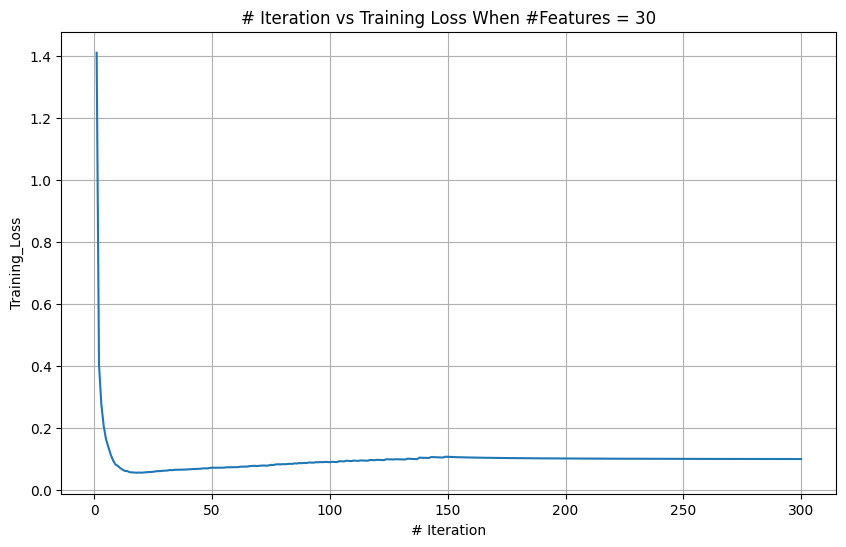

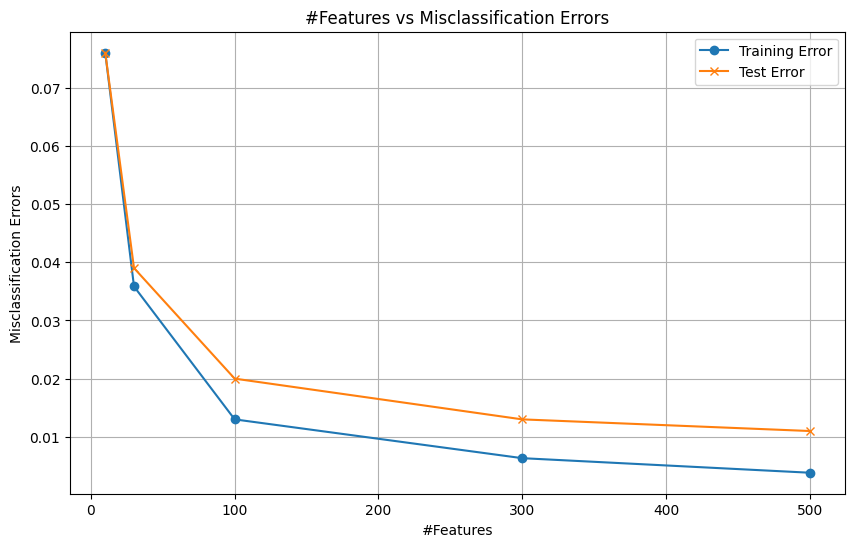

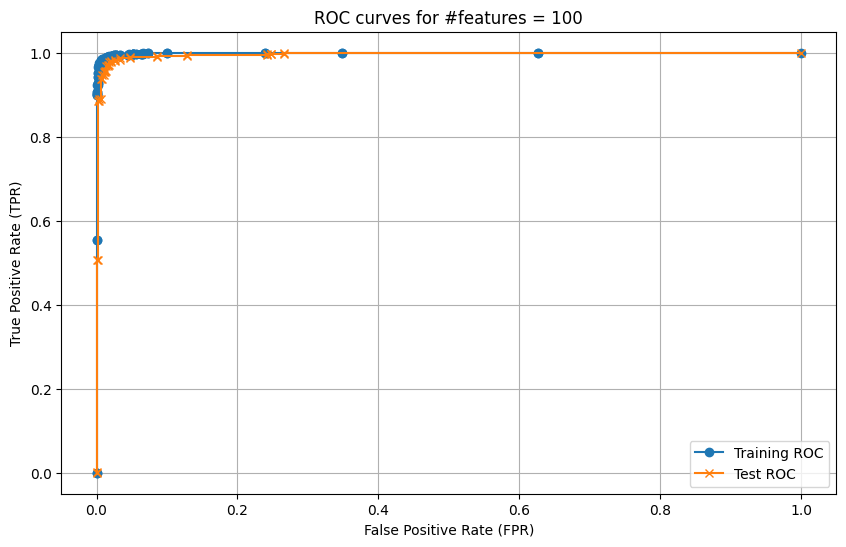

,#Features,Training Errors,Test Errors
0,500,0.003833,0.011
1,300,0.006333,0.013
2,100,0.013000,0.020
3,30,0.035833,0.039
4,10,0.076000,0.076


In [4]:
hw = HW5(train_x, train_y, test_x, test_y,
          eta = 1)
hw.plot_trainloss_30()
hw.plot_misclass_all()
df = hw.report_table()
hw.show_roc(train_y, test_y)

df

## Question (b)
 Repeat point a) on the dexter dataset. (2 points)

In [5]:
#Load dexter
path = "./dexter/"

train_x = dd.read_csv(os.path.join(path, 'dexter_train.csv'),
                         header = None,
                         blocksize = None).compute()

train_y = dd.read_csv(os.path.join(path, 'dexter_train.labels'),
                         header = None,
                         blocksize = None).compute()

test_x = dd.read_csv(os.path.join(path, 'dexter_valid.csv'),
                         header = None,
                         blocksize = None).compute()

test_y = dd.read_csv(os.path.join(path, 'dexter_valid.labels'),
                         header = None,
                         blocksize = None).compute()

# Replace -1 with 0 so that it fits the slides
train_y.replace(-1, 0, inplace = True)
test_y.replace(-1, 0, inplace = True)

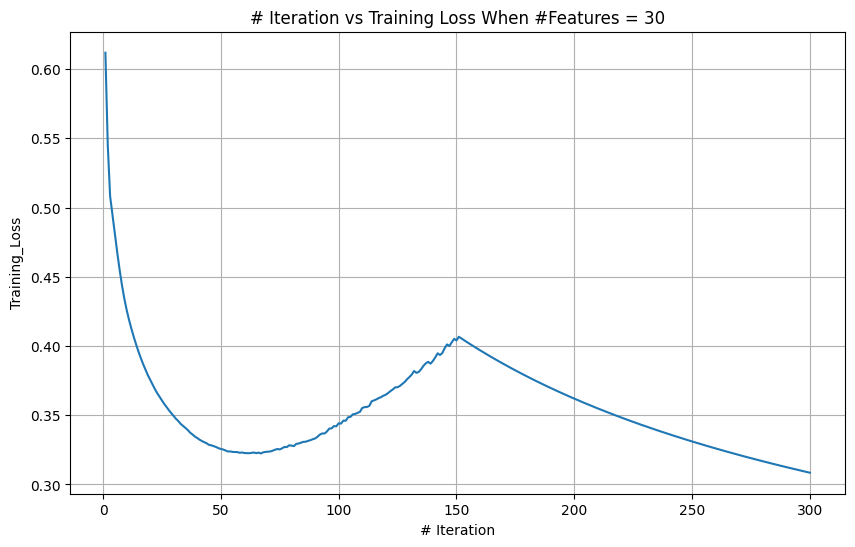

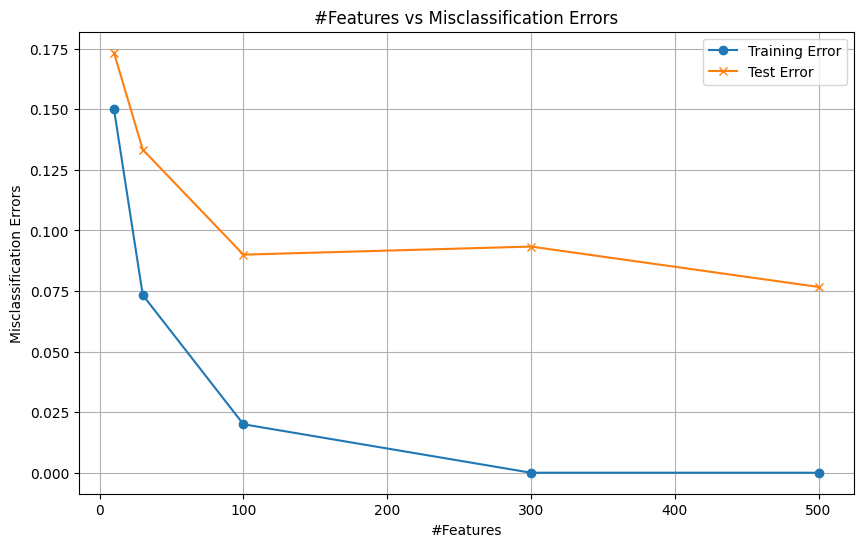

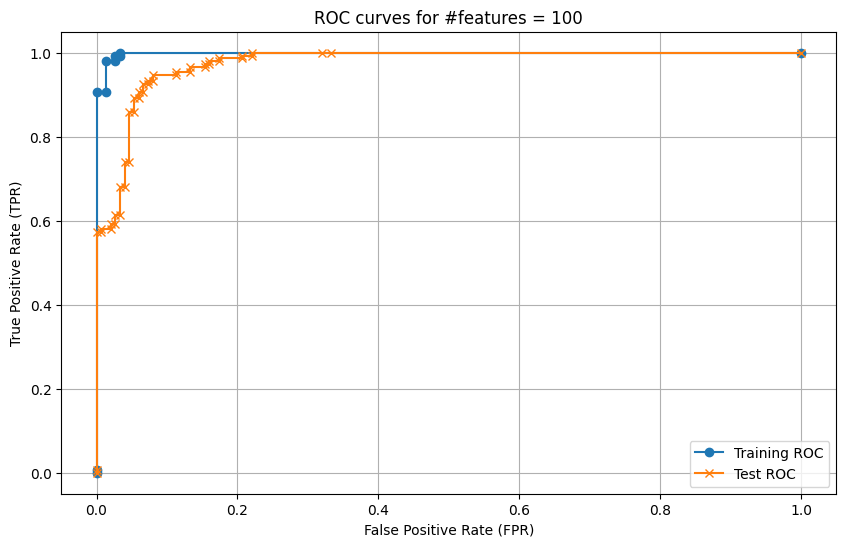

,#Features,Training Errors,Test Errors
0,500,0.000000,0.076667
1,300,0.000000,0.093333
2,100,0.020000,0.090000
3,30,0.073333,0.133333
4,10,0.150000,0.173333


In [6]:
hw = HW5(train_x, train_y, test_x, test_y,
          eta = 0.01)
hw.plot_trainloss_30()
hw.plot_misclass_all()
df = hw.report_table()
hw.show_roc(train_y, test_y)

df

## Question (c)
Repeat point a) on the madelon dataset. (3 points)

In [7]:
# madelon
madelon_x_url = "./MADELON/madelon_train.data"
madelon_y_url = "./MADELON/madelon_train.labels"
madelon_x_test_url = "./MADELON/madelon_valid.data"
madelon_y_test_url = "./MADELON/madelon_valid.labels"
train_x = pd.read_csv(madelon_x_url,
                         header=None,
                         delim_whitespace=True)
train_y = pd.read_csv(madelon_y_url,
                        header=None,
                        delim_whitespace=True)
test_x = pd.read_csv(madelon_x_test_url,
                             header=None,
                             delim_whitespace=True)
test_y = pd.read_csv(madelon_y_test_url,
                             header=None,
                             delim_whitespace=True)

# Replace -1 with 0 so that it fits the slides
train_y.replace(-1, 0, inplace = True)
test_y.replace(-1, 0, inplace = True)

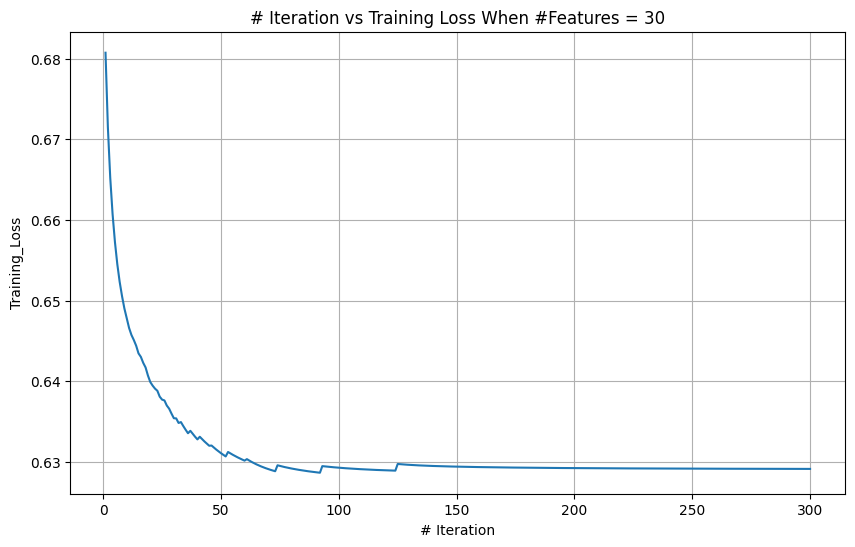

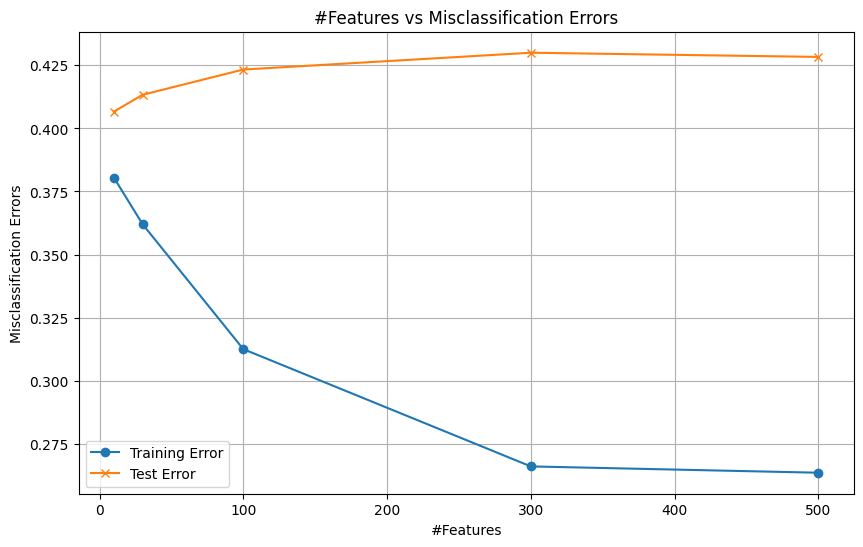

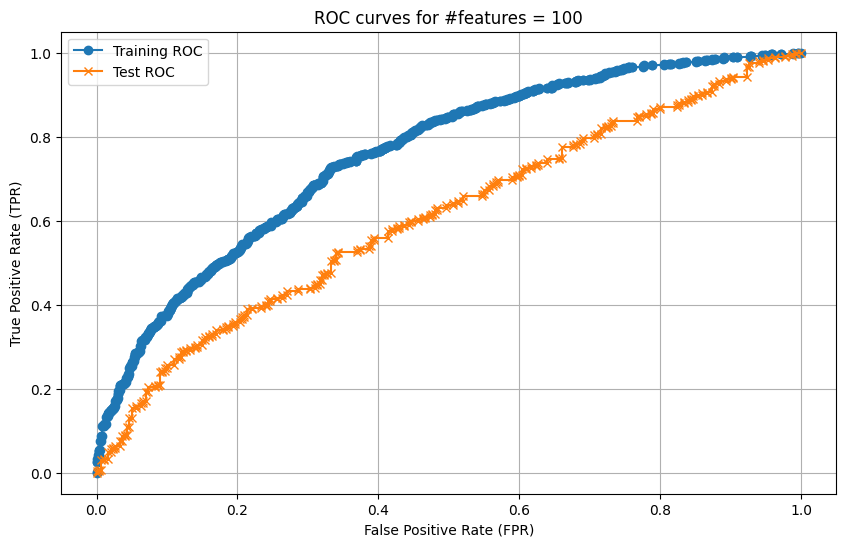

,#Features,Training Errors,Test Errors
0,500,0.2635,0.428333
1,300,0.2660,0.430000
2,100,0.3125,0.423333
3,30,0.3620,0.413333
4,10,0.3805,0.406667


In [8]:
hw = HW5(train_x, train_y, test_x, test_y,
          eta = 0.1)
hw.plot_trainloss_30()
hw.plot_misclass_all()
df = hw.report_table()
hw.show_roc(train_y, test_y)

df